In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba import njit
from scipy.optimize import fmin, minimize_scalar, minimize, root_scalar
from scipy.signal import find_peaks
import pickle
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from Ising_integrals import *
from known_formulas import *
from routines import *

In [17]:
blend = 0.1
p= 5
n_points_T = 700
n_points_more_T = 300

T_kauz, T_dyn = get_Tk_Td(p)

Ts = np.hstack(
    (
        np.linspace(T_kauz, T_dyn, n_points_T),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
#Ts = Ts[:5]
ms = np.empty(len(Ts))
qs = np.empty(len(Ts))
fs = np.empty(len(Ts))
es = np.empty(len(Ts))
ss = np.empty(len(Ts))

for jdx, T in enumerate(tqdm(Ts)):
    J0 = 1 / (2 * T)
    q_init = 1.-1e-6
    m_init = 1.-1e-6
    err = 1
    m = m_init
    q = q_init
    while err > 1e-7:
        m_new = compute_m_standard(m, q, p, 1 / T, J0)
        q_new = compute_q_standard(m, q, p, 1 / T, J0)

        err = max(abs(q_new - q), abs(m_new - m))
        m = blend * m + (1 - blend) * m_new
        q = blend * q + (1 - blend) * q_new

    q_init = q

    ms[jdx] = m
    qs[jdx] = q
    es[jdx] = compute_energy_standard(m, q, p, 1 / T, J0)
    fs[jdx] = compute_free_energy_standard(m, q, p, 1 / T, J0)
    ss[jdx] = (es[jdx] - fs[jdx]) / T

  0%|          | 0/1000 [00:00<?, ?it/s]

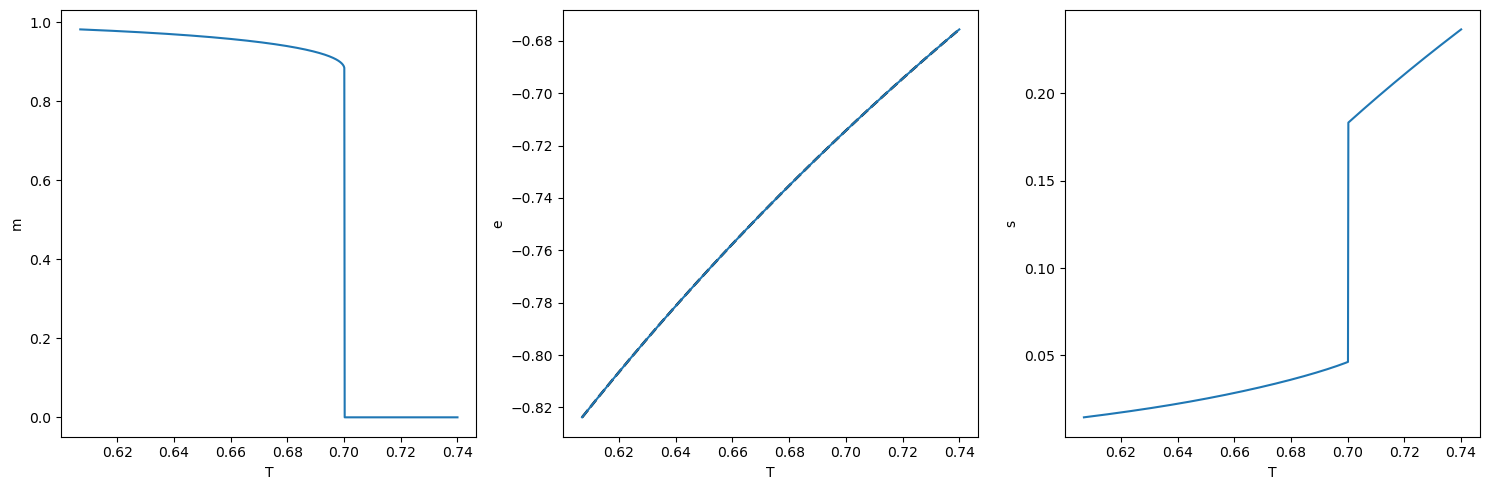

In [18]:
# plot m , e and f
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(Ts, ms)
ax[0].set_ylabel('m')
ax[0].set_xlabel('T')
ax[1].plot(Ts, -0.5/Ts, 'k--', lw=1.8)
ax[1].plot(Ts, es)#+0.5/Ts)
ax[1].set_ylabel('e')
ax[1].set_xlabel('T')
ax[2].plot(Ts, ss)
ax[2].set_ylabel('s')
ax[2].set_xlabel('T')
plt.tight_layout()


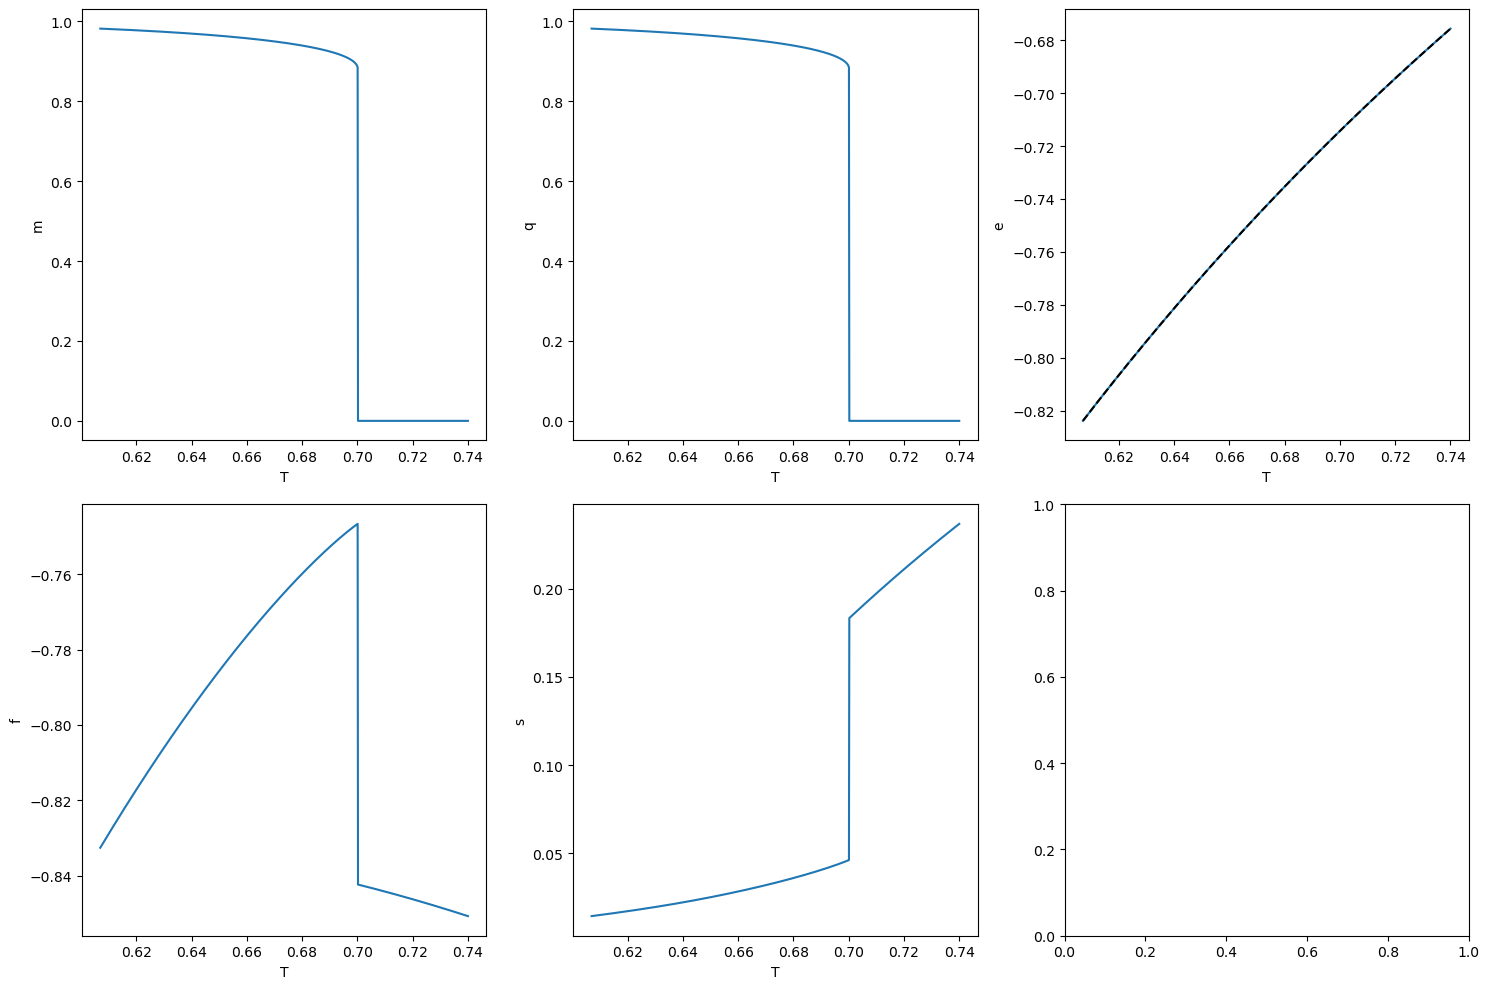

In [19]:
# plot m , q, e, f and s as before, in two rows
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].plot(Ts, ms)
ax[0, 0].set_ylabel('m')
ax[0, 0].set_xlabel('T')
ax[0, 1].plot(Ts, qs)
ax[0, 1].set_ylabel('q')
ax[0, 1].set_xlabel('T')
ax[0, 2].plot(Ts, es)
ax[0, 2].set_ylabel('e')
ax[0, 2].plot(Ts, -0.5/Ts, 'k--')
ax[0, 2].set_xlabel('T')
ax[1, 0].plot(Ts, fs)
ax[1, 0].set_ylabel('f')
ax[1, 0].set_xlabel('T')
ax[1, 1].plot(Ts, ss)
ax[1, 1].set_ylabel('s')
ax[1, 1].set_xlabel('T')
plt.tight_layout()


#### Check with the RS computation

In [20]:
data = observables((len(es)))
    
for jdx, e in enumerate(tqdm(es, desc='RS')):
    m = ms[jdx]
    h, q = fixed_points_h_q(m, e, p)

    data['q'][jdx] = q
    data['h'][jdx] = h
    data['T'][jdx] = 1 / beta_q_e(q, ms[jdx], e, p, h)
    data['s'][jdx] = s_FP(ms[jdx], q, h, p, e)

RS:   0%|          | 0/1000 [00:00<?, ?it/s]

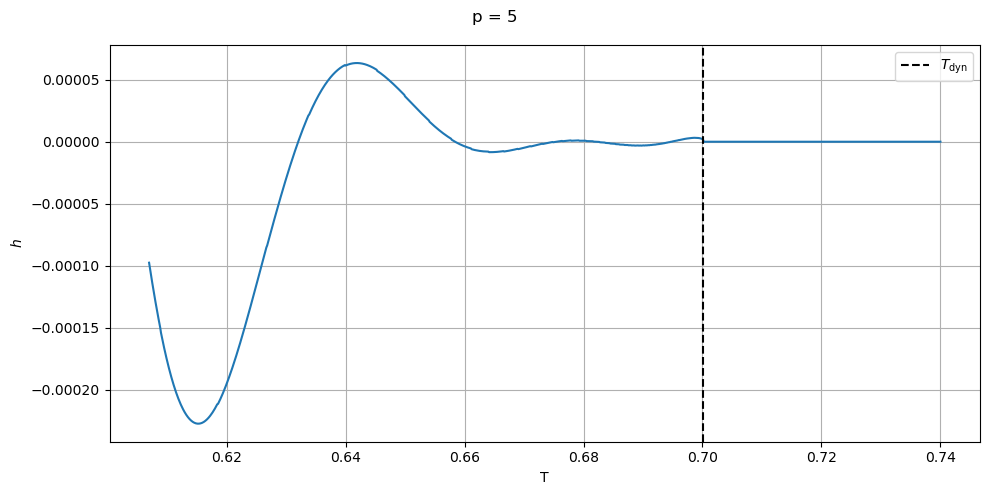

In [21]:
#plot h 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle(f"p = {p}")
ax.plot(Ts, data['h'])
ax.set_ylabel(r'$h$')
ax.axvline(T_dyn, color='k', linestyle='--', label=r'$T_{\rm dyn}$')
ax.set_xlabel('T')
plt.tight_layout()
plt.legend()
plt.grid()

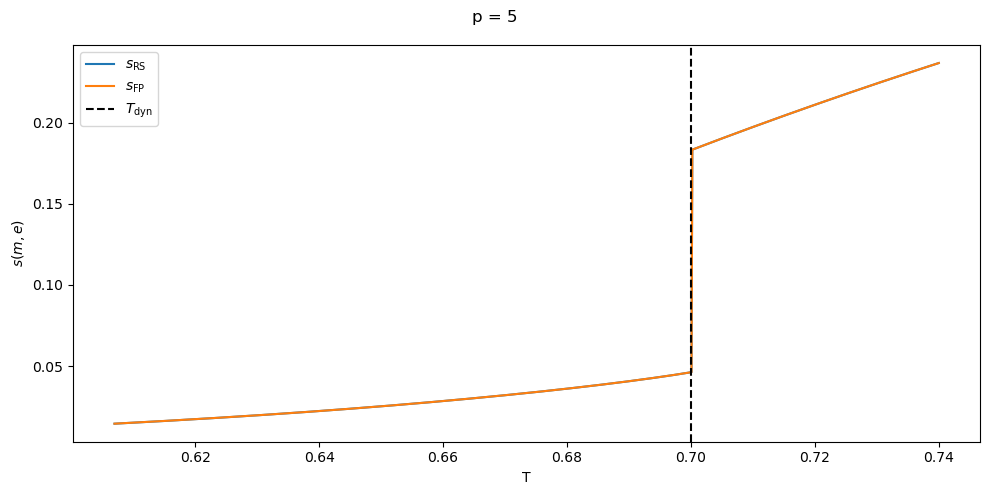

In [22]:
#plot s_FP and s_RS superimposed
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle(f"p = {p}")
ax.plot(Ts, data['s'], label=r'$s_{\rm RS}$')
ax.plot(Ts, ss, label=r'$s_{\rm FP}$')
ax.axvline(T_dyn, color='k', linestyle='--', label=r'$T_{\rm dyn}$')
ax.set_ylabel(r'$s(m,e)$')
ax.set_xlabel('T')
plt.tight_layout()
plt.legend()

#### RS 2

In [23]:
p=5
blend = 0.1
n_points_T = 10
n_points_m = 1_000
n_points_more_T = 4

T_kauz, T_dyn = get_Tk_Td(p)

Teqs = np.hstack(
    (
        np.linspace(T_kauz, T_dyn, n_points_T),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
Teqs = Teqs[5:]
mss = np.empty(len(Teqs))
qs = np.empty(len(Teqs))
fs = np.empty(len(Teqs))
es = np.empty(len(Teqs))
ss = np.empty(len(Teqs))

for jdx, T in enumerate(tqdm(Teqs)):
    J0 = 1 / (2 * T)
    q_init = 1.-1e-6
    m_init = 1.-1e-6
    err = 1
    m = m_init
    q = q_init
    while err > 1e-7:
        m_new = compute_m_standard(m, q, p, 1 / T, J0)
        q_new = compute_q_standard(m, q, p, 1 / T, J0)

        err = max(abs(q_new - q), abs(m_new - m))
        m = blend * m + (1 - blend) * m_new
        q = blend * q + (1 - blend) * q_new

    q_init = q

    mss[jdx] = m
    qs[jdx] = q
    es[jdx] = compute_energy_standard(m, q, p, 1 / T, J0)
    fs[jdx] = compute_free_energy_standard(m, q, p, 1 / T, J0)
    ss[jdx] = (es[jdx] - fs[jdx]) / T

  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
ms = 1-np.logspace(-3, -0.001, n_points_m)
data = observables((len(Teqs), n_points_m))

for jdx, e in enumerate(tqdm(es, desc='RS')):
    for idx, m in enumerate(ms):
        h, q = fixed_points_h_q(m, e, p)

        data['q'][jdx, idx] = q
        data['h'][jdx, idx] = h
        data['T'][jdx, idx] = 1 / beta_q_e(q, m, e, p,h)
        data['delta_f'][jdx, idx] = deltaf_FP(m, q, h, p, e)
        data['s'][jdx, idx] = s_FP(m, q, h, p, e)
        data['dAT'][jdx, idx] = dAT_condition(
            q, m, h, beta_q_e(q, m, e, p, h), beta_q_e(q, m, e, p, h) / 2, p
        )


RS:   0%|          | 0/9 [00:00<?, ?it/s]

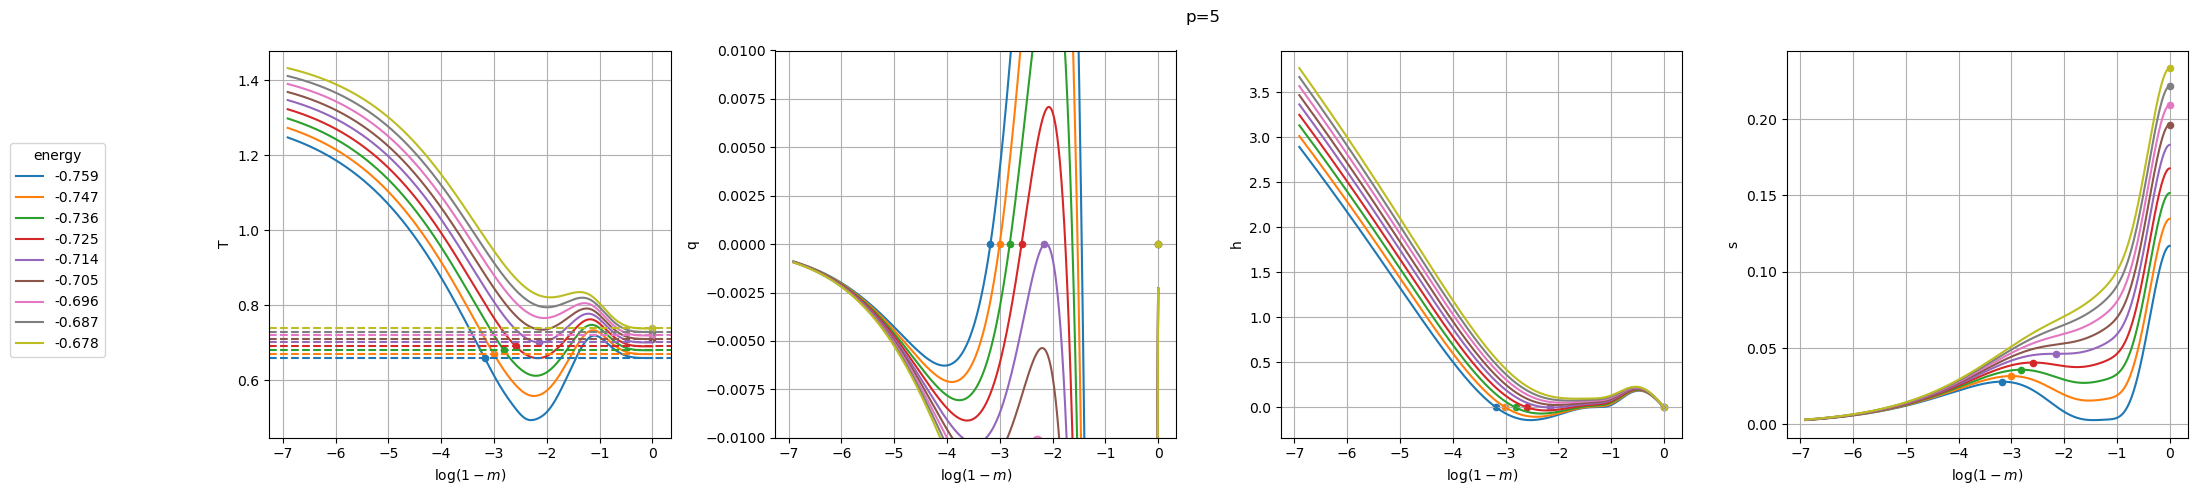

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f"p={p}")

data_filtered = {
    key: value for key, value in data.items() if key in ["T", "s", "h","q"]
}

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    color = f"C{jdx:d}"
    stable_idxs = data["dAT"][jdx, :] > 0

    for idx, (key, item) in enumerate(data_filtered.items()):
        #plot_dashed_instable(axs[idx], ms, item[jdx], stable_idxs, color, legend_name)
        if (key =='q'): 
            axs[idx].plot(np.log(1-ms), item[jdx]-ms, c=color, label=legend_name)
            #axs[idx].plot(np.log(1-ms), np.log(1-ms), c='k', label=legend_name)
        else: axs[idx].plot(np.log(1-ms), item[jdx], c=color, label=legend_name)
        axs[idx].set_ylabel(key)
        axs[idx].set_xlabel(r"$\text{log}(1-m)$")
        axs[idx].grid(True)
for jdx, e in enumerate(es): 
    color = f"C{jdx:d}"   
    axs[3].scatter(np.log(1-mss[jdx]), ss[jdx], c=color, s=20, zorder=10)
    axs[0].scatter(np.log(1-mss[jdx]), Teqs[jdx], c=color, s=20)
    axs[1].scatter(np.log(1-mss[jdx]), 0, c=color, s=20, zorder=10)
    axs[2].scatter(np.log(1-mss[jdx]), 0, c=color, s=20)
    axs[0].axhline(y=-0.5/e, color=color, linestyle="--")

position_T = list(data_filtered.keys()).index("T")
#axs[position_T].axhline(y=T_kauz, color="r", linestyle="--", label=r"$T_k$")
#axs[position_T].axhline(y=T_dyn, color="g", linestyle="--", label=r"$T_d$")

handles, labels = [], []
ax = axs[position_T]
for handle, label in zip(*ax.get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)

lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(-0.1, 0.5), title="energy")
axs[1].set_ylim(-0.01, 0.01)
plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
#plt.savefig(
#    f"./imgs/FPpspin_p{p}_small.png",
#    bbox_extra_artists=(lgd,),
#    bbox_inches="tight",
#    dpi=360,
#)

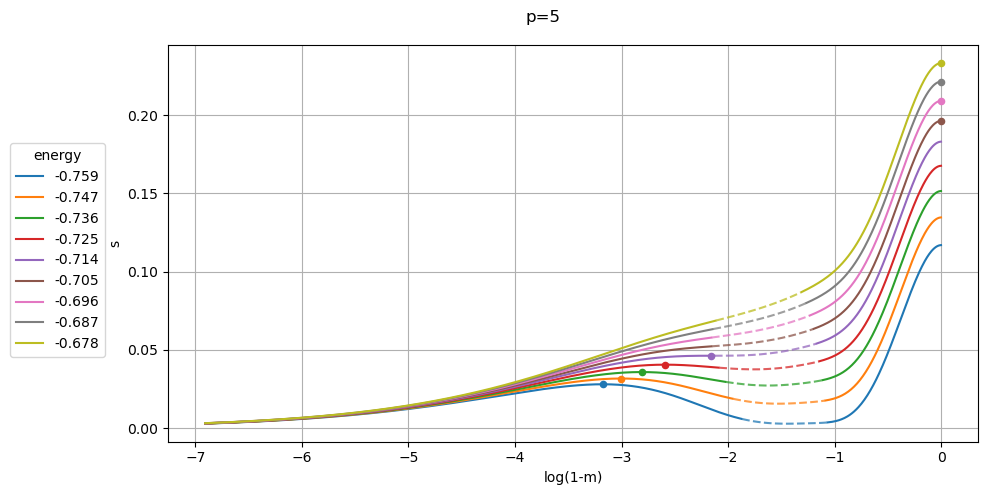

In [30]:
#plot s vs log(1-m) 
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
fig.suptitle(f"p={p}")

for jdx, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    color = f"C{jdx:d}"
    stable_idxs = data["dAT"][jdx, :] > 0

    plot_dashed_instable(ax, np.log(1-ms), data["s"][jdx], stable_idxs, color, legend_name)
    ax.scatter(np.log(1-mss[jdx]), ss[jdx], c=color, s=20, zorder=10)

ax.set_ylabel("s")
ax.set_xlabel("log(1-m)")
ax.grid(True)

handles, labels = [], []
for handle, label in zip(*ax.get_legend_handles_labels()):
    if (handle, label) not in zip(handles, labels):
        handles.append(handle)
        labels.append(label)

lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(-0.1, 0.5), title="energy")

plt.tight_layout(rect=[0.1, 0, 1, 1])

plt.tight_layout()
plt.savefig(
    f"./imgs/s_p{p}_s_vs_log1m.png",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
    dpi=360,
)